### We will calculate multiple scores to quantify the quality of the generated samples

In [51]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import torch

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### PCA and KS test

In [37]:
real_data = datasets.ImageFolder('data/png_clasificados/',
                                     transform=tfs.Compose([tfs.Resize((112, 112)),
                                      tfs.Grayscale(1),
                                      #tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                      #tfs.ToTensor()
                                                           ]))
fake_data = datasets.ImageFolder('output_data/',
                                     transform=tfs.Compose([tfs.Resize((112, 112)),
                                      tfs.Grayscale(1),
                                      #tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                      #tfs.ToTensor()
                                                           ]))
real_data = np.vstack([np.array(data[0]).ravel() for data in real_data])
fake_data = np.vstack([np.array(data[0]).ravel() for data in fake_data])[:1200,:]
all_data = np.vstack([real_data, fake_data])

In [18]:
real_data.shape

(1282, 12544)

In [38]:
real_labels = np.ones((1282, 1))
fake_labels = np.zeros((1200, 1))
all_labels = np.vstack([real_labels, fake_labels])

In [26]:
all_labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [39]:
from sklearn.decomposition import PCA # using randomized Singular Value Decomposition

Xp = PCA(svd_solver='randomized', n_components=2, random_state=1).fit_transform(all_data)
Xp

array([[-1122.33633289,  -955.16484517],
       [-1122.33633289,  -955.16484517],
       [-1702.69117473,   185.69534072],
       ...,
       [ 3142.20139213,  5690.08566155],
       [-3185.33963551,   158.70592515],
       [ 5104.77564643, -2873.25357023]])

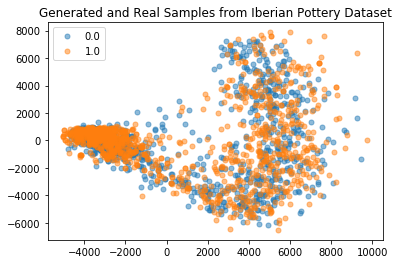

In [87]:
#labels_dict = {0.0:'Generated', 1.0:'Real'}

pca_df = pd.DataFrame(Xp, columns=['PC1', 'PC2'])
labels = pd.DataFrame(all_labels, columns=['class'])
#labels = labels.replace(labels_dict)
pca_df = pd.concat([pca_df, labels], axis=1)

groups = pca_df.groupby('class')

# Plot

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
        ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=5, label=name, alpha=0.5)
        #print(group)
        #for i, row in group.iterrows():
            #print(row.id)
            #ax.annotate(row.id, (row.x, row.y), alpha=0.5)

#ax.set_xlim([-7000, 50000])
#ax.set_ylim([-3000, 6000])
plt.title('Generated and Real Samples from Iberian Pottery Dataset')
ax.legend()
#plt.savefig('ouput_media/pca_comparison.png', dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

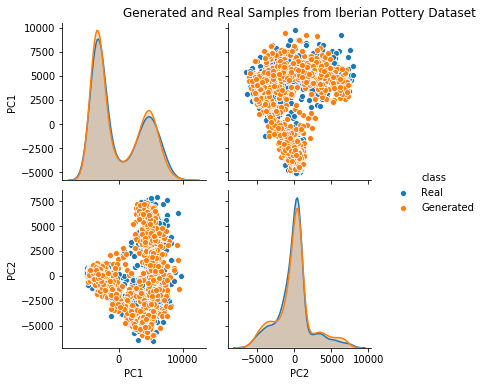

In [72]:
plt.tight_layout()
sns.pairplot(pca_df, hue='class')
plt.title('Generated and Real Samples from Iberian Pottery Dataset')
plt.savefig('ouput_media/pca_comparison.png', bbox_inches='tight',  dpi=300)

#### KS-test to measure similarity 

In [93]:
import scipy.stats

density_real = scipy.stats.gaussian_kde(Xp[:1282].ravel())
density_fake = scipy.stats.gaussian_kde(Xp[1282:].ravel())

In [97]:
stats.ks_2samp(density_real.resample(100).ravel(), density_fake.resample(100).ravel())

Ks_2sampResult(statistic=0.15000000000000002, pvalue=0.19304165192468994)

### FID score

In [110]:
!python -m pytorch_fid --dim 64 data/png_processed/ output_data/clean

FID:  0.023434669358734728


In [111]:
!python -m pytorch_fid --dim 64 data/png_processed/ output_data/all

FID:  0.024568938544338503


### TODO https://arxiv.org/pdf/1802.02664.pdf https://github.com/KhrulkovV/geometry-score